Implementing a basic DE solver for the neutrino winds in terms of psi

Runge-Kutta method from Wikipedia:
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/25f03454fd25957cc63be11ec534efdce349c52f">
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/95bdbb2e3aa83735085c0aadd577162c69e4056a">
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/81398071e8f180ac143bfdf4598ff47bf79eb689">
I use $\psi$ in place of t, and {r,v} as y. I calculate separate k values for r and v to get y'={r',v'}

Questions/next steps:

Use scipy integrator to find solutions?
Use absolute value of f1,f2 and minimize the distance between their zeros as a function of v0

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
np.seterr(all='raise')

#AV=False
cs=1
M=10
G=1
mB=1
dPdS=1
Se=0
rho=1
T=1
r0=1

def ndf1(psi,coords):
    '''Dimensionless f1 function, takes t,(x,y) and returns 1-exp[2y]'''
    try:
        return 1-np.exp(2*coords[1])
    except:
        print("Error in ndf1 at ",psi,", ",coords)
        return -1
def absndf1(psi,coords):
    '''Absolute value of ndf1'''
    return abs(ndf1(psi,coords))

def ndf2(psi,coords):
    '''Dimensionless f2 function, takes t,(x,y) and returns (GM/r0*cs^2)exp[-x]-2'''
    try:
        return np.exp(-coords[0])*G*M/((cs**2)*r0)-2
    except:
        print("Error in ndf2 at ",psi,", ",coords)
        return -1
def absndf2(psi,coords):
    '''Absolute value of ndf2'''
    return abs(ndf2(psi,coords))

def CoupledRungeKuttaStep(af1,af2,fn,t,dt): 
    """Takes functions af1 and af2, state f(n), t and dt, and steps f(n) to f(n+dt) using an RK4 method with arbitrary input functions f1 and f2
    Returns t+dt,f(n+dt)"""  
    f1k1=dt*af1(t,fn)
    f2k1=dt*af2(t,fn)
    f1k2=dt*af1(t+dt/2,fn+np.array([f1k1/2,f2k1/2]))
    f2k2=dt*af2(t+dt/2,fn+np.array([f1k1/2,f2k1/2]))
    f1k3=dt*af1(t+dt/2,fn+np.array([f1k2/2,f2k2/2]))
    f2k3=dt*af2(t+dt/2,fn+np.array([f1k2/2,f2k2/2]))
    f1k4=dt*af1(t+dt,fn+np.array([f1k3,f2k3]))
    f2k4=dt*af2(t+dt,fn+np.array([f1k3,f2k3]))
    return np.array([t+dt,np.array([fn[0]+(f1k1+2*f1k2+2*f1k3+f1k4)/6,fn[1]+(f2k1+2*f2k2+2*f2k3+f2k4)/6])])

def percentChange(curr,step):
    '''Takes a current state and a new state (vectors) and calculates the percent change'''
    return 100*abs(np.linalg.norm((step-curr)/np.linalg.norm(curr)))

def adaptRK(currState,pc,t,dt,AV):
    """Adapts dt to ensure the change in (x,u) is between .1 and 1 percent
    This system does not always behave as expected, so the adaptation iteratively finds a new dt to correct the error
    This new dt can be either larger or smaller, independent of the initial percent change
    Takes a state (x,u), a percent change, t, dt, and absolute value (boolean)"""
    ddt=1.5
    if pc>1:
        pc2=1e10 #initialize dummy percent changes, used to track movement in % change while finding new dt
        prevpc2=1e10
        while pc2>1:
            dt=dt*ddt
            if AV:
                step2=CoupledRungeKuttaStep(absndf1,absndf2,currState,t,dt)
            else:
                step2=CoupledRungeKuttaStep(ndf1,ndf2,currState,t,dt) #calculate hypothetical next step using new dt
            pc2=percentChange(currState,step2[1])
            if pc2>prevpc2: #if we're moving in the wrong direction, invert our change in dt
                ddt=1/ddt
            prevpc2=pc2
        return dt #once we've found a working dt, take a step using it
    elif pc<.1: 
        pc2=1e-10 #initialize dummy percent changes, used to track movement in % change while finding new dt
        prevpc2=1e-10
        while pc2<.1:
            dt=dt*ddt
            if AV:
                step2=CoupledRungeKuttaStep(absndf1,absndf2,currState,t,dt)
            else:
                step2=CoupledRungeKuttaStep(ndf1,ndf2,currState,t,dt) #calculate hypothetical next step using new dt
            pc2=percentChange(currState,step2[1])
            if pc2<prevpc2: #if we're moving in the wrong direction, invert our change in dt
                ddt=1/ddt
            prevpc2=pc2
        return dt #once we've found a working dt, take a step using it

def generateFunc(x0,u0,itermax,AV):
    """Generates a trace of wind behavior with initial conditions x0 and u0 (dimensionless) using the RK4 method with adaptation in dt
    Takes x0, u0, max iteration count and returns a 2D array tracking t, x, and u"""
    xsol=np.array([x0])
    usol=np.array([u0])
    tarray=np.array([0])
    t=0
    dt=.01
    i=0
    currState=np.array([xsol[-1],usol[-1]])
    
    #Main loop for adaptive RK solver
    #Exit conditions are based on values for exp(x)
    #Using zero points for f1 and f2 only works if you change ndf1 and ndf2 to return absolute values, and then you don't see the full curve
    #Setting a max iteration count doesn't always work well - the solution curves may be cut
    while np.exp(currState[0])>1e-6 and np.exp(currState[0])<5: #and abs(ndf1(t,currState))>.001 and ndf2(t,currState)>.001:
        
        #Load the current position of the system to determine if adaptation is necessary
        currState=np.array([xsol[-1],usol[-1]])
        
        #Calculate the next integration step using the RK function defined above
        if AV:
            step=CoupledRungeKuttaStep(absndf1,absndf2,currState,t,dt)
        else:
            step=CoupledRungeKuttaStep(ndf1,ndf2,currState,t,dt)
        
        #Calculate percent change from current state to predicted next state
        try:
            pc=percentChange(currState,step[1])
        except:
            print("Error at %change, currState: ",currState," step: ",step)
            break
        
        #If the percent change is too large or too small, change dt to compensate
        if pc>1 or pc<.1:
            dt=adaptRK(currState,pc,t,dt,AV)
        if AV:
            step=CoupledRungeKuttaStep(absndf1,absndf2,currState,t,dt)
        else:
            step=CoupledRungeKuttaStep(ndf1,ndf2,currState,t,dt)
        
        xsol=np.append(xsol,step[1][0]) #update solution curves with next step
        usol=np.append(usol,step[1][1])
        t=t+dt
        tarray=np.append(tarray,t)
    #print("*********Iteration complete***********, exit conditions t=",t,", exp(x)=",np.exp(currState[0]))
    return np.array((tarray,xsol,usol))

def makePlot(u0,AV):
    """Generates a plot of one wind curve
    Takes u0 and generates a curve
    Returns 0, prints a plot of the wind curve"""
        
    plt.figure(1)
    plt.xlim(1,5)
    plt.ylim(0,5)

    func=generateFunc(0,np.log(u0),50,AV)
    plt.scatter(np.exp(func[1]),np.exp(func[2]),s=.5);
    return 0

def makePlots(umin,umax,du,AV):
    """Generates a plot of wind curves
    Takes umin, umax, du and generates a curve for u0 (x0=0), then increments u0 by du and generates a new curve, repeating until u0=umax
    Returns 0, prints a plot of the different wind curves"""
        
    plt.figure(1)
    plt.xlim(1,5)
    plt.ylim(0,5)

    for i in np.arange(umin,umax,du):
        #print("\n*******iteration********* ",i,"\n")
        func=generateFunc(0,np.log(i),50,AV)
        plt.scatter(np.exp(func[1]),np.exp(func[2]),s=.5);
    return 0

def findZeros(u0):
    """Finds the t values where f1 and f2 reach zero, and returns the difference
    Takes starting velocity u0
    Returns tu-tx"""
    x=0
    u=u0
    t=0
    dt=.01
    i=0
    currState=np.array([x,u])
    xfound=False
    ufound=False
    tu=0
    tx=0
    
    while (not ufound) and (not xfound):
        print(currState,ndf1(t,currState),ndf2(t,currState))
        
        #Load the current position of the system to determine if adaptation is necessary
        currState=np.array([x,u])
        
        #Calculate the next integration step using the RK function defined above
        step=CoupledRungeKuttaStep(ndf1,ndf2,currState,t,dt)
        
        #Calculate percent change from current state to predicted next state
        try:
            pc=percentChange(currState,step[1])
        except:
            print("Error at %change, currState: ",currState," step: ",step)
            break
        
        #If the percent change is too large or too small, change dt to compensate
        if pc>1 or pc<.1:
            dt=adaptRK(currState,pc,t,dt,False)
        step=CoupledRungeKuttaStep(ndf1,ndf2,currState,t,dt)
        
        if np.sign(ndf1(t,currState))!=np.sign(ndf1(t,step[1])):# and t!=0:
            print("found x at ",t)
            xfound=True
            tx=t
        if np.sign(ndf2(t,currState))!=np.sign(ndf2(t,step[1])):# and t!=0:
            print("found u at ",t)
            ufound=True
            tu=t
        
        x=step[1][0] #update solution curves with next step
        u=step[1][1]
        t=t+dt
        
    #print("*********Iteration complete***********, exit conditions t=",t,", exp(x)=",np.exp(currState[0]))
    return tu-tx

def findV0(guess):
    return sco.newton(findZeros,guess,tol=10**-10)


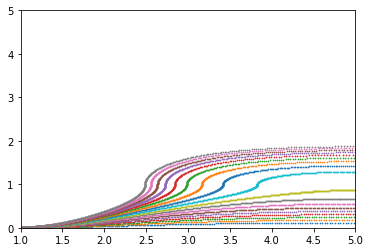

In [75]:
makePlots(.001,.01,.0005,AV=True);

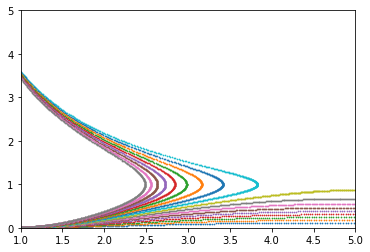

In [70]:
makePlots(.001,.01,.0005,AV=False);

0

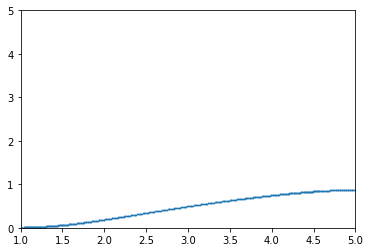

In [82]:
makePlot(.005,False)

In [81]:
findZeros(.005)

[0.    0.005] -0.010050167084167949 8.0
[0.    0.005] -0.010050167084167949 8.0
[-4.55000271e-08  5.03608744e-03] -0.01012306996502943 8.000000455000283
[-9.13289258e-08  5.07217488e-03] -0.010195978111999127 8.0000009132893
[-1.37486720e-07  5.10826233e-03] -0.010268891525487822 8.000001374867296
[-1.83973433e-07  5.14434977e-03] -0.010341810205906299 8.000001839734502
[-2.30789090e-07  5.18043722e-03] -0.01041473415366534 8.000002307891162
[-2.77933713e-07  5.21652467e-03] -0.010487663369175504 8.00000277933751
[-3.25407326e-07  5.25261213e-03] -0.01056059785284802 8.00000325407379
[-3.73209954e-07  5.28869958e-03] -0.010633537605093446 8.000003732100232
[-4.21341619e-07  5.32478704e-03] -0.010706482626322789 8.000004213417082
[-4.69802347e-07  5.36087450e-03] -0.01077943291694683 8.000004698024572
[-5.18592160e-07  5.39696196e-03] -0.010852388477376795 8.000005185922943
[-5.67711082e-07  5.43304942e-03] -0.01092534930802369 8.000005677112432
[-6.17159137e-07  5.46913689e-03] -0.0109

[-3.31650354e-05  1.69451446e-02] -0.034471107843434545 8.000331655853223
[-3.33207005e-05  1.69812335e-02] -0.034545776467043154 8.000333212556585
[-3.34767025e-05  1.70173225e-02] -0.034620450494815325 8.000334772628674
[-3.36330414e-05  1.70534114e-02] -0.03469512992717472 8.000336336069735
[-3.37897171e-05  1.70895004e-02] -0.03476981476454499 8.000337902880013
[-3.39467298e-05  1.71255894e-02] -0.034844505007350035 8.000339473059752
[-3.41040794e-05  1.71616783e-02] -0.03491920065601306 8.000341046609197
[-3.42617659e-05  1.71977673e-02] -0.0349939017109584 8.0003426235286
[-3.44197895e-05  1.72338563e-02] -0.03506860817260948 8.000344203818198
[-3.45781500e-05  1.72699453e-02] -0.03514332004139065 8.000345787478244
[-3.47368476e-05  1.73060343e-02] -0.035218037317725104 8.000347374508978
[-3.48958822e-05  1.73421233e-02] -0.035292760002037404 8.000348964910646
[-3.50552539e-05  1.73782123e-02] -0.03536748809475121 8.000350558683497
[-3.52149627e-05  1.74143014e-02] -0.03544222159

[-0.0001134   0.03022647] -0.0623176139329924 8.00113404470178
[-0.00011368  0.03026257] -0.06239430022757997 8.001136857854654
[-0.00011396  0.03029866] -0.062470992084958876 8.001139674468103
[-0.00011424  0.03033475] -0.06254768950556788 8.001142494542382
[-0.00011453  0.03037085] -0.0626243924898453 8.001145318077745
[-0.00011481  0.03040694] -0.06270110103823012 8.001148145074445
[-0.00011509  0.03044303] -0.06277781515116088 8.001150975532738
[-0.00011537  0.03047912] -0.06285453482907677 8.001153809452877
[-0.00011566  0.03051522] -0.06293126007241634 8.001156646835113
[-0.00011594  0.03055131] -0.06300799088161857 8.001159487679704
[-0.00011623  0.0305874 ] -0.06308472725712222 8.001162331986906
[-0.00011651  0.03062349] -0.0631614691993665 8.001165179756967
[-0.0001168   0.03065959] -0.06323821670879037 8.001168030990144
[-0.00011708  0.03069568] -0.06331496978583284 8.001170885686692
[-0.00011737  0.03073177] -0.06339172843093288 8.001173743846865
[-0.00011765  0.03076786] -0

[-0.00026789  0.04585595] -0.0960490109922505 8.002679246738646
[-0.00026854  0.0459101 ] -0.0961677180145295 8.002685751554445
[-0.00026919  0.04596425] -0.09628643798987535 8.002692264409259
[-0.00026984  0.0460184 ] -0.09640517091983059 8.002698785303982
[-0.00027049  0.04607255] -0.09652391680593908 8.002705314239508
[-0.00027115  0.0461267 ] -0.09664267564974405 8.002711851216727
[-0.0002718   0.04618085] -0.09676144745278936 8.002718396236535
[-0.00027246  0.046235  ] -0.09688023221661868 8.002724949299822
[-0.00027311  0.04628915] -0.09699902994277654 8.002731510407482
[-0.00027377  0.0463433 ] -0.09711784063280726 8.002738079560412
[-0.00027443  0.04639745] -0.09723666428825561 8.002744656759496
[-0.00027509  0.0464516 ] -0.09735550091066614 8.002751242005639
[-0.00027575  0.04650575] -0.09747435050158404 8.002757835299725
[-0.00027641  0.0465599 ] -0.09759321306255475 8.002764436642654
[-0.00027707  0.04661405] -0.0977120885951237 8.002771046035315
[-0.00027773  0.0466682 ] -0

[-0.00072464  0.07442717] -0.16050394286502057 8.007248988155123
[-0.00072627  0.07450844] -0.160692587423934 8.007265300053156
[-0.0007279   0.07458971] -0.16088126303239014 8.007281631139954
[-0.00072953  0.07467098] -0.16106996969601362 8.007297981418759
[-0.00073117  0.07475225] -0.16125870742043036 8.00731435089282
[-0.00073281  0.07483353] -0.16144747621126743 8.007330739565388
[-0.00073444  0.0749148 ] -0.16163627607415298 8.007347147439713
[-0.00073609  0.07499607] -0.16182510701471653 8.007363574519045
[-0.00073773  0.07507734] -0.1620139690385889 8.007380020806636
[-0.00073938  0.07515861] -0.16220286215140223 8.007396486305735
[-0.00074102  0.07523988] -0.1623917863587898 8.007412971019601
[-0.00074267  0.07532116] -0.1625807416663858 8.00742947495148
[-0.00074432  0.07540243] -0.16276972807982615 8.007445998104632
[-0.00074598  0.0754837 ] -0.1629587456047481 8.007462540482308
[-0.00074763  0.07556497] -0.1631477942467896 8.007479102087766
[-0.00074929  0.07564625] -0.16333

[-0.00205479  0.12312458] -0.2792182597820445 8.020569053595036
[-0.00206117  0.12330774] -0.27968695683421685 8.020633002487887
[-0.00206757  0.12349091] -0.2801558293560289 8.020697059064839
[-0.00207397  0.12367407] -0.28062487742081355 8.020761223368114
[-0.00208038  0.12385724] -0.28109410110194166 8.020825495439956
[-0.00208681  0.12404041] -0.2815635004728214 8.020889875322634
[-0.00209324  0.12422358] -0.28203307560689916 8.02095436305843
[-0.00209969  0.12440675] -0.28250282657765946 8.021018958689652
[-0.00210615  0.12458992] -0.28297275345862394 8.021083662258633
[-0.00211261  0.1247731 ] -0.2834428563233531 8.021148473807722
[-0.00211909  0.12495628] -0.2839131352454447 8.02121339337929
[-0.00212558  0.12513945] -0.28438359029853455 8.02127842101573
[-0.00213208  0.12532263] -0.284854221556297 8.021343556759458
[-0.00213859  0.12550581] -0.2853250290924436 8.02140880065291
[-0.00214511  0.125689  ] -0.2857960129807251 8.021474152738545
[-0.00215164  0.12587218] -0.286267173

[-0.00495614  0.18706323] -0.45372098610399747 8.04968446521177
[-0.0049717   0.18733898] -0.4545229157359818 8.049840798202343
[-0.00498728  0.18761473] -0.4553253033447757 8.049997409777063
[-0.00500289  0.18789048] -0.45612814922803 8.0501543001066
[-0.00501853  0.18816624] -0.45693145368363663 8.050311469361755
[-0.0050342   0.18844201] -0.45773521700973063 8.050468917713463
[-0.00504989  0.18871778] -0.4585394395046889 8.050626645332795
[-0.00506561  0.18899355] -0.45934412146713144 8.050784652390963
[-0.00508136  0.18926933] -0.4601492631959212 8.050942939059308
[-0.00509714  0.18954512] -0.46095486499016447 8.051101505509317
[-0.00511294  0.18982091] -0.4617609271492107 8.0512603519126
[-0.00512877  0.19009671] -0.4625674499726531 8.051419478440915
[-0.00514463  0.19037251] -0.4633744337603294 8.05157888526615
[-0.00516052  0.19064832] -0.4641818788123213 8.051738572560334
[-0.00517643  0.19092414] -0.46498978542895464 8.051898540495632
[-0.00519238  0.19119995] -0.4657981539108

[-0.01407092  0.30305385] -0.83328182471162 8.141703815404348
[-0.01411378  0.3034722 ] -0.8348163761424359 8.142138451129185
[-0.01415671  0.30389058] -0.8363522941701711 8.14257390556667
[-0.01419972  0.30430897] -0.837889580230897 8.143010179533256
[-0.01424282  0.30472739] -0.8394282357626139 8.143447273846478
[-0.01428599  0.30514583] -0.8409682622052537 8.143885189324934
[-0.01432924  0.30556429] -0.8425096610006837 8.144323926788296
[-0.01437257  0.30598278] -0.84405243359271 8.14476348705732
[-0.01441598  0.30640129] -0.8455965814270803 8.145203870953829
[-0.01445946  0.30681982] -0.8471421059514879 8.145645079300731
[-0.01450303  0.30723837] -0.8486890086155738 8.14608711292201
[-0.01454668  0.30765695] -0.8502372908709317 8.146529972642737
[-0.01459041  0.30807555] -0.8517869541711101 8.146973659289067
[-0.01463421  0.30849417] -0.8533379999716157 8.14741817368824
[-0.0146781   0.30891281] -0.8548904297299178 8.147863516668584
[-0.01472207  0.30933148] -0.8564442449054501 8.1

[-0.04491152  0.50600359] -1.7511174629851318 8.459353094440903
[-0.04504662  0.50665564] -1.7547075142092936 8.46076627996303
[-0.045182    0.50730779] -1.7583028517653183 8.462182553415712
[-0.04531766  0.50796006] -1.7619034854376743 8.4636019202686
[-0.04545359  0.50861243] -1.7655094250345584 8.4650243860043
[-0.04558981  0.50926491] -1.769120680387966 8.466449956118405
[-0.0457263   0.50991751] -1.7727372613537633 8.467878636119536
[-0.04586307  0.51057021] -1.7763591778117607 8.469310431529387
[-0.04600012  0.51122302] -1.7799864396657878 8.470745347882753
[-0.04613745  0.51187595] -1.7836190568437638 8.472183390727583
[-0.04627506  0.51252899] -1.7872570392977742 8.473624565625006
[-0.04641295  0.51318213] -1.790900397004143 8.475068878149385
[-0.04655112  0.51383539] -1.7945491399635078 8.47651633388834
[-0.04668957  0.51448876] -1.7982032782008934 8.477966938442805
[-0.04682831  0.51514224] -1.801862821765789 8.479420697427056
[-0.04696732  0.51579584] -1.8055277807322203 8.4

[-0.14369195  0.82008193] -4.156014266427185 9.54528402596113
[-0.14417309  0.82118578] -4.167409806431142 9.550840214873991
[-0.14465554  0.82229028] -4.178837196225089 9.556414323855634
[-0.14513932  0.82339542] -4.190296557229747 9.56200641891921
[-0.14562443  0.82450121] -4.201788011480641 9.567616566405771
[-0.14611086  0.82560765] -4.2133116816320015 9.573244832986314
[-0.14659863  0.82671474] -4.224867690960678 9.57889128566386
[-0.14708774  0.82782248] -4.236456163370094 9.584555991775519
[-0.14757819  0.82893088] -4.248077223394236 9.590239018994604
[-0.14806998  0.83003994] -4.259730996201651 9.595940435332736
[-0.14856312  0.83114966] -4.2714176075995045 9.601660309141975
[-0.14905762  0.83226004] -4.283137184037645 9.607398709116962
[-0.14955347  0.83337109] -4.294889852612711 9.613155704297089
[-0.15005069  0.8344828 ] -4.30667574107227 9.618931364068668
[-0.15054927  0.83559518] -4.318494977818982 9.624725758167129
[-0.15104921  0.83670823] -4.3303476919148025 9.630538956

[-0.60714835  1.45003271] -17.17533452967251 16.351906176539718
[-0.60913798  1.45192527] -17.244260635735177 16.3884559200556
[-0.6111356   1.45382207] -17.31360336314641 16.425225721237105
[-0.61314125  1.45572313] -17.383366412653857 16.462217501664643
[-0.615155    1.45762848] -17.45355352879099 16.49943320544882
[-0.61717689  1.45953814] -17.524168500525224 16.536874799562085
[-0.61920696  1.46145215] -17.595215161917647 16.574544274176258
[-0.62124528  1.46337052] -17.66669739279446 16.61244364300607
[-0.62329188  1.46529329] -17.738619119430478 16.65057494365882
[-0.62534682  1.46722049] -17.810984315244873 16.68894023799031
[-0.62741016  1.46915213] -17.883797001509485 16.72754161246711
[-0.62948194  1.47108824] -17.957061248069877 16.766381178535426
[-0.63156222  1.47302887] -18.0307811740795 16.805461072996533
[-0.63365104  1.47497402] -18.104960948747177 16.8447834583891
[-0.63574847  1.47692373] -18.179604792098228 16.884350523378366
[-0.63785456  1.47887803] -18.2547169757

[-6.36424127  4.67847339] -11577.98124273335 5805.040612347372
[-6.41788613  4.7053684 ] -12217.870502405161 6125.065637113241
[-6.47458147  4.73378902] -12932.524758430367 6482.477735452587
[-6.53469472  4.76391899] -13735.859722908795 6884.235314605393
[-6.59866403  4.79597741] -14645.472928939726 7339.137798329832
[-6.66701756  4.83022839] -15683.947642991541 7858.477612152677
[-6.74040001  4.86699431] -16880.753151869045 8456.990366618302
[-6.79250193  4.89309535] -17785.42307687309 8909.403432104235
[-6.84747423  4.92063182] -18792.44914977096 9412.998876932448
[-6.9056514   4.94977098] -19920.243572260657 9976.983303684927
[-6.96743002  4.98071113] -21191.91626386741 10612.912267017538
[-7.03328516  5.01368984] -22636.875161681055 11335.490448124507
[-7.10379258  5.04899499] -24293.128527158693 12163.722841431001
[-7.17965934  5.08698014] -26210.676875344325 13122.610765162233
[-7.23364104  5.11400569] -27666.435585510164 13850.57105831797
[-7.29070808  5.14257409] -29293.2984853

[-61.40534224  32.20053726] -9.311749595418586e+27 4.655874797709295e+27
[-61.85040141  32.42306684] -1.4531753862960656e+28 7.265876931480383e+27
[-62.31836253  32.6570474 ] -2.320336464990071e+28 1.1601682324950362e+28
[-62.82556743  32.91064985] -3.8532505946880346e+28 1.9266252973440184e+28
[-63.40614469  33.20093848] -6.886027538811118e+28 3.4430137694055608e+28
[-63.83663699  33.41618463] -1.0590810214149882e+29 5.295405107074982e+28
[-64.28085855  33.63829541] -1.6513995241816995e+29 8.256997620908561e+28
[-64.74742974  33.871581  ] -2.6331854554613777e+29 1.316592727730699e+29
[-65.25218239  34.12395733] -4.362071117610981e+29 2.1810355588055073e+29
[-65.82792648  34.41182938] -7.757740041127953e+29 3.878870020564006e+29
[-66.25254538  34.62413882] -1.1861643418051643e+30 5.930821709025867e+29
[-66.68744755  34.84158991] -1.8324008173896986e+30 9.162004086948562e+29
[-67.13876028  35.06724628] -2.877551518270658e+30 1.4387757591353194e+30
[-67.61719717  35.30646472] -4.64307401

[-443.53051378  223.26312303] -8.39237119546752e+193 4.1961855977335545e+193
[-446.23769079  224.61671153] -1.2577569430816292e+195 6.288784715408552e+194
[-448.05625821  225.52599524] -7.751585065053283e+195 3.875792532526672e+195
[-451.58535074  227.29054151] -2.6427490882271493e+197 1.3213745441132843e+197
[-453.8422101   228.41897119] -2.5246285960533837e+198 1.2623142980265583e+198
[-455.28223276  229.13898252] -1.0655930776506135e+199 5.327965388252805e+198
[-457.92461688  230.46017458] -1.4968015837032622e+200 7.4840079185155175e+199
[-459.45541779  231.22557503] -6.918032855636875e+200 3.4590164278182676e+200
[-463.89088139  233.44330683] -5.838213723021228e+202 2.9191068615113e+202
[-467.79614492  235.3959386 ] -2.899441773691916e+204 1.4497208868467106e+204
[-469.99969659  236.49771443] -2.6260604520094744e+205 1.3130302260048967e+205
[-474.48835413  238.7420432 ] -2.337243281098088e+207 1.1686216405491859e+207
[-475.8330973   239.41441478] -8.968472026600263e+207 4.484236013

0.18936537153350716

In [ ]:
#Testing the CoupledRungeKuttaStep function with a known DE
#It works as expected

def testf(t,x):
    return -3*x[0]+np.sqrt(2)*x[1]
def testf2(t,x):
    return np.sqrt(2)*x[0]-2*x[1]

def generateTestFunc(x0,y0):
    x1=np.array([x0])
    x2=np.array([y0])
    t=0
    while t<10:
        step=CoupledRungeKuttaStep(testf,testf2,np.array([x1[-1],x2[-1]]),t,.01)
        x1=np.append(x1,step[1][0])
        x2=np.append(x2,step[1][1])
        t=t+.01
        #print(xstep)
    return np.array([x1,x2])

func2=generateTestFunc(2,-1)
plt.scatter(func2[0],func2[1])

In [ ]:
import scipy.integrate as sc

def ndf1(psi,coords):
    return 1-np.exp(2*coords[1])

def ndf2(psi,coords):
    return np.exp(-coords[0])*G*M/((cs**2)*r0)-2

lambda t,y: (ndf1(t,y),ndf2(t,y))

sol=sc.solve_ivp(lambda t,y: (ndf1(t,y),ndf2(t,y)),(0,np.log(5)),(0,np.log(.001)))

In [ ]:
sol['t']

In [ ]:
sol['y']

In [ ]:
plt.scatter(np.exp(sol['y'][0]),np.exp(sol['y'][1]))